In [1]:
import matplotlib.pyplot as plt

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.tree import DecisionTreeClassifier
from sklearn import datasets, metrics, tree, ensemble
from sklearn.model_selection import cross_val_score, learning_curve, train_test_split, validation_curve

%pylab inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Populating the interactive namespace from numpy and matplotlib


In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

In [4]:
age_mean = train['age'].mean()
train['age'] = train['age'].fillna(age_mean)
test['age'] = test['age'].fillna(age_mean)


hypertension_mean = train['hypertension'].mean()
train['hypertension'] = train['hypertension'].fillna(hypertension_mean)
test['hypertension'] = test['hypertension'].fillna(hypertension_mean)


# train['heart_disease']

heart_disease_mean = train['heart_disease'].mean()
train['heart_disease'] = train['heart_disease'].fillna(heart_disease_mean)
test['heart_disease'] = test['heart_disease'].fillna(heart_disease_mean)


# train['avg_glucose_level']

avg_glucose_level_mean = train['avg_glucose_level'].mean()
train['avg_glucose_level'] = train['avg_glucose_level'].fillna(avg_glucose_level_mean)
test['avg_glucose_level'] = test['avg_glucose_level'].fillna(avg_glucose_level_mean)


# train['bmi'] 

bmi_mean = train['bmi'].mean()
train['bmi'] = train['bmi'].fillna(bmi_mean)
test['bmi'] = test['bmi'].fillna(bmi_mean)

In [5]:
train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


In [6]:
test.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,37061,Male,19.0,0,0,No,Private,Rural,92.61,16.8,never smoked
1,42333,Male,53.0,0,0,Yes,Govt_job,Urban,94.03,26.5,NaN
2,58964,Female,51.0,0,0,Yes,Private,Rural,127.22,31.0,smokes
3,34063,Female,17.0,0,0,No,Private,Rural,112.15,19.8,NaN
4,43682,Female,41.0,0,0,Yes,Govt_job,Urban,112.17,27.5,never smoked


In [7]:
cat_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for f in cat_features:
    train[f] = train[f].fillna('nan')
    test[f] = test[f].fillna('nan')

In [8]:
# smoothed target encoding
def smoothed_target_encoding(data, feature_name, target_name, C=10):
    global_y_mean = data[target_name].mean()
    K = data.groupby(feature_name).size()
    y_mean = data.groupby(feature_name)[target_name].mean()
    output = (y_mean*K + global_y_mean*C)/(K+C)
    return dict(output)

In [9]:
# WoE and IV
# https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html

In [10]:
gender_dict =  smoothed_target_encoding(train, 'gender', 'stroke', C=10)
train ['gender'] = train ['gender'].map(gender_dict)
test ['gender'] = test ['gender'].map(gender_dict)

In [11]:
replace_dict = smoothed_target_encoding(train, 'ever_married', 'stroke', C=10)
train ['ever_married'] = train ['ever_married'].map(replace_dict )
test ['ever_married'] = test ['ever_married'].map(replace_dict)

In [12]:
replace_dict =  smoothed_target_encoding(train, 'work_type', 'stroke', C=10)
train ['work_type'] = train ['work_type'].map(replace_dict)
test ['work_type'] = test ['work_type'].map( replace_dict)

replace_dict =  smoothed_target_encoding(train, 'Residence_type', 'stroke', C=10)
train ['Residence_type'] = train ['Residence_type'].map(replace_dict)
test ['Residence_type'] = test ['Residence_type'].map( replace_dict)


replace_dict =  smoothed_target_encoding(train, 'smoking_status', 'stroke', C=10)
train ['smoking_status'] = train ['smoking_status'].map(replace_dict)
test ['smoking_status'] = test ['smoking_status'].map( replace_dict)

In [13]:
train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,0.019244,3.0,0,0,0.005282,0.000518,0.017298,95.12,18.0,0.011450,0
1,30468,0.019244,58.0,1,0,0.024460,0.018118,0.018033,87.96,39.2,0.017240,0
2,16523,0.016577,8.0,0,0,0.005282,0.018118,0.018033,110.89,17.6,0.011450,0
3,56543,0.016577,70.0,0,0,0.024460,0.018118,0.017298,69.04,35.9,0.027764,0
4,46136,0.019244,14.0,0,0,0.005282,0.001413,0.017298,161.28,19.1,0.011450,0


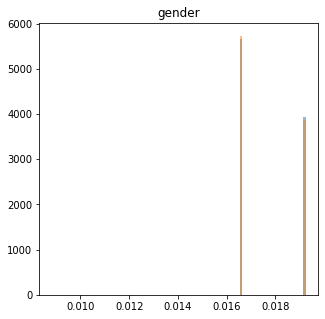

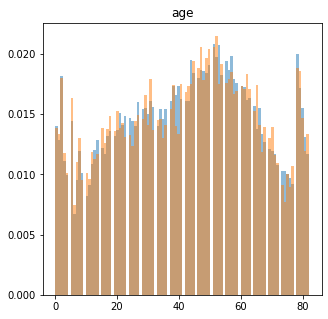

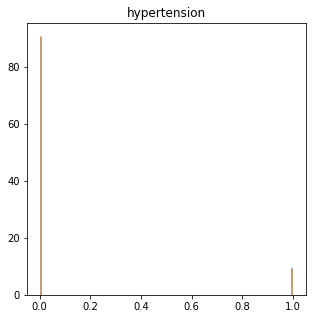

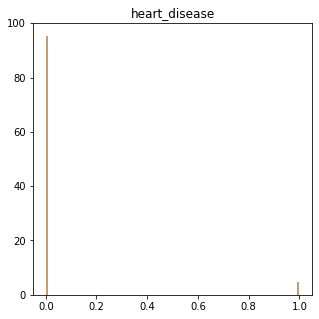

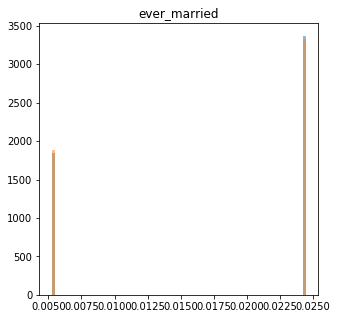

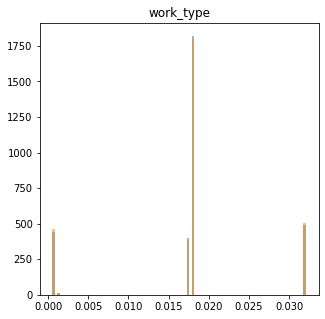

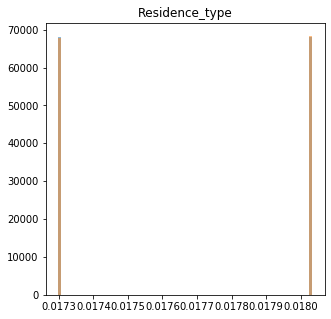

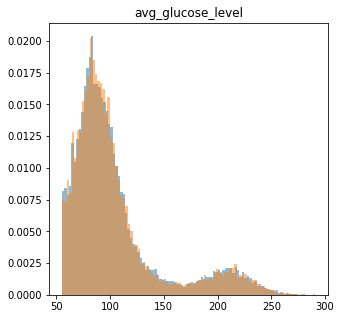

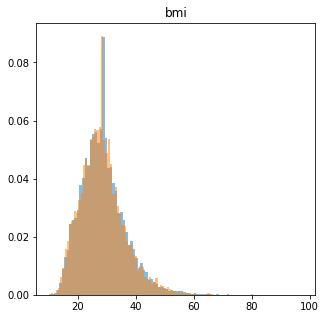

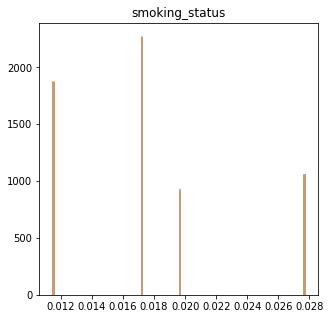

In [14]:
for i in train.columns[1: -1]:
#     print(i)
    plt.figure(figsize=(5,5))
    plt.hist(train[i], bins = 100, alpha = 0.5, label = 'train',density = True)
    plt.hist(test[i], bins = 100, alpha = 0.5, label = 'test',density = True)
    
    plt.title(i)
    plt.show()

In [17]:
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
import seaborn as sns

def make_corr_heatmap(X):
    X_corr = X.corr()
    X_corr[np.isfinite(X_corr )==0 ] =0

    Z=linkage(X_corr, 'complete') 
    leaves = leaves_list(Z)
    
    
    from operator import itemgetter
    high_correlated_pairs = []
    pairs = []
    columns = X_corr.columns
    for idx, rows in X_corr.iterrows():
        for col in columns:
            if abs(rows[col]) > 0.01 and idx != col:
                if [idx, col, rows[col]] not in pairs and [col, idx, rows[col]] not in pairs:
                    pairs.append([idx, col, rows[col]])
    pairs = sorted(pairs, key=itemgetter(2))
    for j in pairs:
        if abs(j[2])>0.75:
            print(j[0], '\t', j[1], '\t', j[2])
            high_correlated_pairs.append(j[0])

    
    

    plt.figure(figsize=(18, 18))
    sns.heatmap(X[X.columns[leaves]].corr(), cmap = 'rainbow')
    return high_correlated_pairs
    #print(X_corr)

In [18]:
y = train['stroke']

In [19]:
X = train.copy()
del X['stroke']
del X['id']
del X['ever_married'] #just common sense
X.head()

,gender,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,0.019244,3.0,0,0,0.000518,0.017298,95.12,18.0,0.011450
1,0.019244,58.0,1,0,0.018118,0.018033,87.96,39.2,0.017240
2,0.016577,8.0,0,0,0.018118,0.018033,110.89,17.6,0.011450
3,0.016577,70.0,0,0,0.018118,0.017298,69.04,35.9,0.027764
4,0.019244,14.0,0,0,0.001413,0.017298,161.28,19.1,0.011450


In [20]:
del test['id']
del test['ever_married']
test.head()

,gender,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,0.019244,19.0,0,0,0.018118,0.017298,92.61,16.8,0.017240
1,0.019244,53.0,0,0,0.017351,0.018033,94.03,26.5,0.011450
2,0.016577,51.0,0,0,0.018118,0.017298,127.22,31.0,0.019719
3,0.016577,17.0,0,0,0.018118,0.017298,112.15,19.8,0.011450
4,0.016577,41.0,0,0,0.017351,0.018033,112.17,27.5,0.017240


[]

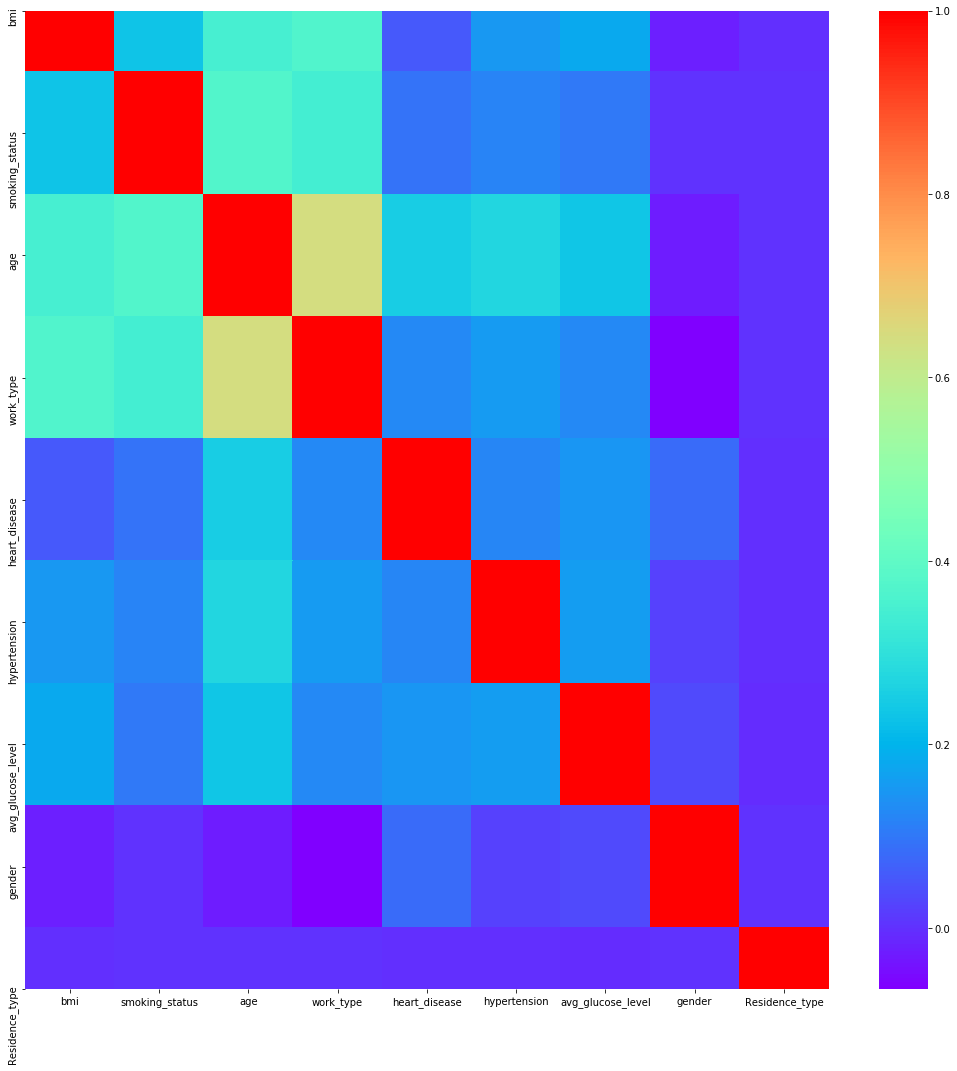

In [21]:
make_corr_heatmap(X)

In [22]:
#LogisticRegression
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression()
lg.fit(X, y)

/home/maria/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

/home/maria/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/maria/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/maria/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/maria/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/maria/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the numb

[0.84847805 0.84847845 0.84847845 0.84847845 0.84847845 0.84847845]
[0.84739634 0.84729197 0.84729197 0.84729197 0.84729197 0.84729197]


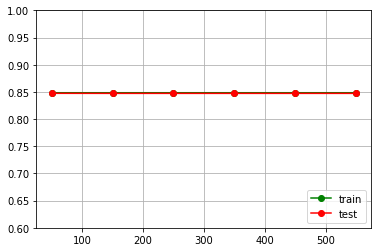

In [41]:
x_seq = list(range(50, 560, 100))
train_scores, test_scores = validation_curve(lg, X, y,'max_iter', x_seq, cv=5, 
                                             scoring='roc_auc')
print(train_scores.mean(axis=1))
print(test_scores.mean(axis = 1))

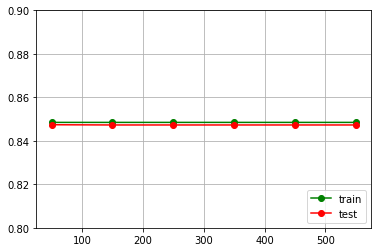

In [42]:
pylab.grid(True)
pylab.plot(x_seq, train_scores.mean(axis = 1), 'g-', marker='o', label='train')
pylab.plot(x_seq, test_scores.mean(axis = 1), 'r-', marker='o', label='test')
pylab.ylim((0.8, 0.9))
pylab.legend(loc='lower right')

/home/maria/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/maria/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/maria/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/maria/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/maria/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reac

[0.84845579 0.84844464 0.84810905 0.68193557 0.66926489]
[0.84729006 0.84728461 0.8469056  0.68091851 0.66832699]


/home/maria/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


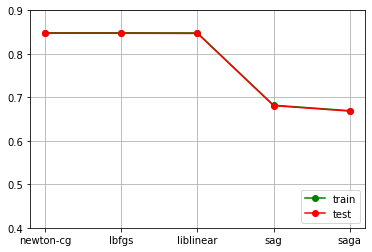

In [24]:
x_seq = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
train_scores, test_scores = validation_curve(lg, X,
                                             y, 'solver', x_seq, cv=5, 
                                             scoring='roc_auc')
print(train_scores.mean(axis=1))
print(test_scores.mean(axis = 1))

[0.84845579 0.84847845 0.84849136 0.848504   0.84851667]
[0.84729006 0.84729197 0.84729838 0.84729901 0.84730029]


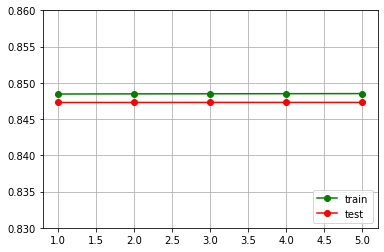

In [50]:
x_seq = [1, 2, 3, 4, 5]
train_scores, test_scores = validation_curve(lg, X,
                                             y, 'C', x_seq, cv=5, 
                                             scoring='roc_auc')
print(train_scores.mean(axis=1))
print(test_scores.mean(axis = 1))


pylab.grid(True)
pylab.plot(x_seq, train_scores.mean(axis = 1), 'g-', marker='o', label='train')
pylab.plot(x_seq, test_scores.mean(axis = 1), 'r-', marker='o', label='test')
pylab.ylim((0.83, 0.86))
pylab.legend(loc='lower right')

In [51]:
#choosing the best parameteres
lg = LogisticRegression(max_iter=200, solver = 'newton-cg', C = 2 )
lg.fit(X, y)
lg.score(X, y)
test_lg = lg.predict_proba(test)

sample['stroke']= test_lg
sample.to_csv('submission_logistic_reg.csv', index =None)

In [27]:
#DecisionTree

clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

[0.80669034 0.87758072 0.95514503 0.99434546 0.99961667]
[0.79178529 0.8196818  0.68639267 0.5806058  0.54407823]


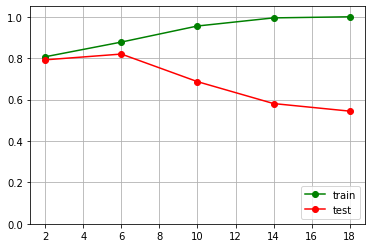

In [28]:
x_seq = list(range(2, 20, 4))
train_scores, test_scores = validation_curve(clf, X,
                                             y, 'max_depth', x_seq, cv=5, 
                                             scoring='roc_auc')
print(train_scores.mean(axis=1))
print(test_scores.mean(axis = 1))


pylab.grid(True)
pylab.plot(x_seq, train_scores.mean(axis = 1), 'g-', marker='o', label='train')
pylab.plot(x_seq, test_scores.mean(axis = 1), 'r-', marker='o', label='test')
pylab.ylim((0, 1.05))
pylab.legend(loc='lower right')

[0.83815682 0.83814001 0.83813993 0.83813993 0.83813993]
[0.8263502  0.82628235 0.82628235 0.82628235 0.82628235]


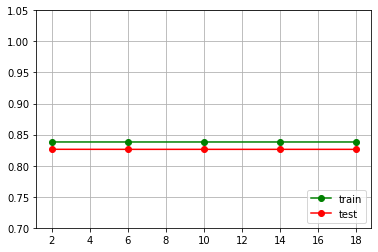

In [29]:
x_seq = list(range(2, 20, 4))
train_scores, test_scores = validation_curve(clf, X,
                                             y, 'min_samples_split', x_seq, cv=5, 
                                             scoring='roc_auc')
print(train_scores.mean(axis=1))
print(test_scores.mean(axis = 1))


pylab.grid(True)
pylab.plot(x_seq, train_scores.mean(axis = 1), 'g-', marker='o', label='train')
pylab.plot(x_seq, test_scores.mean(axis = 1), 'r-', marker='o', label='test')
pylab.ylim((0.7, 1.05))
pylab.legend(loc='lower right')

[0.83927543 0.83925584 0.84137115 0.84141196 0.84141196]
[0.82680638 0.82677245 0.8298974  0.82987804 0.82987804]


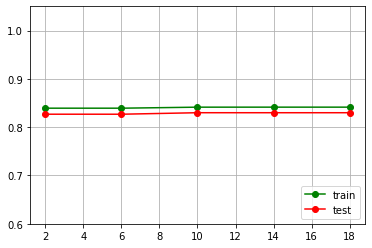

In [30]:
x_seq = list(range(2, 20, 4))
train_scores, test_scores = validation_curve(clf, X,
                                             y, 'min_samples_leaf', x_seq, cv=5, 
                                             scoring='roc_auc')
print(train_scores.mean(axis=1))
print(test_scores.mean(axis = 1))


pylab.grid(True)
pylab.plot(x_seq, train_scores.mean(axis = 1), 'g-', marker='o', label='train')
pylab.plot(x_seq, test_scores.mean(axis = 1), 'r-', marker='o', label='test')
pylab.ylim((0.6, 1.05))
pylab.legend(loc='lower right')

In [31]:
dt = DecisionTreeClassifier(max_depth=2, min_samples_split = 6, min_samples_leaf = 6)
dt.fit(X, y)
print(dt.score(X, y))
test_dt = dt.predict_proba(test)

sample['stroke']= test_dt
sample.to_csv('submission_decisiontree.csv', index =None)

0.9823339222025933


In [32]:
#RandomForest

rf_classifier = ensemble.RandomForestClassifier(n_estimators = 70, max_depth = 14, random_state = 1)
rf_classifier.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=14, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=70,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [33]:
x_seq = list(range(5, 60, 10))
train_scores, test_scores = validation_curve(rf_classifier, X,
                                             y, 'n_estimators', x_seq, cv=5, scoring = 'roc_auc')
print(test_scores.mean(axis = 1))

[0.6773853  0.75627784 0.77920361 0.79211795 0.79905033 0.80429317]


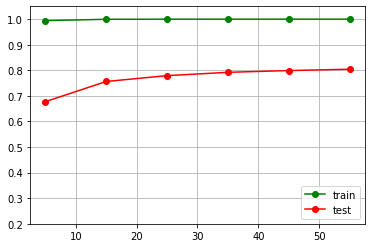

In [34]:
pylab.grid(True)
pylab.plot(x_seq, train_scores.mean(axis = 1), 'g-', marker='o', label='train')
pylab.plot(x_seq, test_scores.mean(axis = 1), 'r-', marker='o', label='test')
pylab.ylim((0.2, 1.05))
pylab.legend(loc='lower right')

[0.78007206 0.80482788 0.81033583 0.80878554 0.80564832]


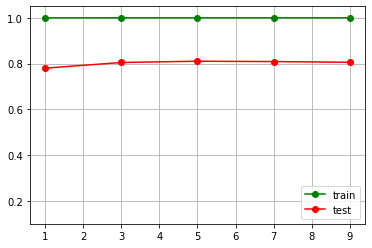

In [36]:
x_seq = list(range(1, 10, 2))
train_scores, test_scores = validation_curve(rf_classifier, X,
                                             y, 'max_features', x_seq, cv=5, scoring='roc_auc')
print(test_scores.mean(axis = 1))

pylab.grid(True)
pylab.plot(x_seq, train_scores.mean(axis = 1), 'g-', marker='o', label='train')
pylab.plot(x_seq, test_scores.mean(axis = 1), 'r-', marker='o', label='test')
pylab.ylim((0.1, 1.05))
pylab.legend(loc='lower right')

[0.82816554 0.84218486 0.84586825 0.84423878 0.83612228 0.82496549]


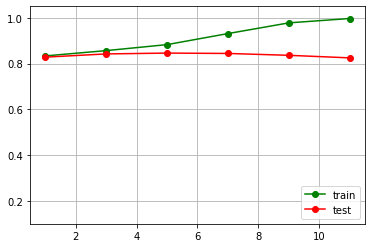

In [37]:
x_seq = list(range(1, 12, 2))
train_scores, test_scores = validation_curve(rf_classifier, X,
                                             y, 'max_depth', x_seq, cv=5, scoring='roc_auc')
print(test_scores.mean(axis = 1))

pylab.grid(True)
pylab.plot(x_seq, train_scores.mean(axis = 1), 'g-', marker='o', label='train')
pylab.plot(x_seq, test_scores.mean(axis = 1), 'r-', marker='o', label='test')
pylab.ylim((0.1, 1.05))
pylab.legend(loc='lower right')

In [38]:
rf =  ensemble.RandomForestClassifier(max_depth=2, n_estimators = 50, max_features = 4)
dt.fit(X, y)
print(dt.score(X, y))
test_dt = dt.predict_proba(test)

sample['stroke']= test_dt
sample.to_csv('submission_randomforest', index =None)

0.9823339222025933
